# Dual-Model Analysis (OOF Validation)

이 노트북에서는 **OOF (Out-of-Fold)** 예측값을 사용하여 모델의 **진짜 성능**을 검증합니다.
이전 분석(Test Set)은 학습된 모델이 다시 자기 자신을 평가하는 형태가 되어 과적합(Overfitting)된 결과를 보여주었을 수 있습니다.
OOF 데이터는 모델이 학습하지 않은 데이터에 대한 예측이므로, 실전 성능과 가장 유사합니다.

## 검증 포인트
1.  **Return Model (OOF):** 과적합 없는 진짜 상관계수(IC) 확인.
2.  **Risk Model (OOF):** 변동성 예측의 정확도 확인.
3.  **Strategy (OOF):** 전체 기간에 대한 시뮬레이션 성과.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# 프로젝트 루트 경로 추가
sys.path.append(str(Path.cwd().parent))

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## 1. OOF 데이터 로드
파이프라인 실행 시 저장된 `oof_predictions.csv`를 로드합니다.


In [2]:
# OOF 데이터 로드
oof_path = Path("../results/oof_predictions.csv")
if not oof_path.exists():
    raise FileNotFoundError("OOF prediction file not found. Please run the pipeline first.")

df = pd.read_csv(oof_path)
print(f"✅ OOF Data loaded: {df.shape}")
df.head()


✅ OOF Data loaded: (2500, 5)


,date_id,actual_return,pred_return,pred_risk,allocation
0,2020,0.019660,0.007193,0.012885,0.279102
1,2021,0.015686,0.010543,0.005681,0.928005
2,2022,-0.000644,-0.001209,0.005753,0.000000
3,2023,0.005151,-0.003653,0.007326,0.000000
4,2024,0.002243,-0.009552,0.006411,0.000000


## 2. Return Model 검증 (True Performance)
OOF 예측값과 실제 수익률의 관계를 확인합니다. 여기서 나오는 상관계수(IC)가 모델의 진짜 실력입니다.


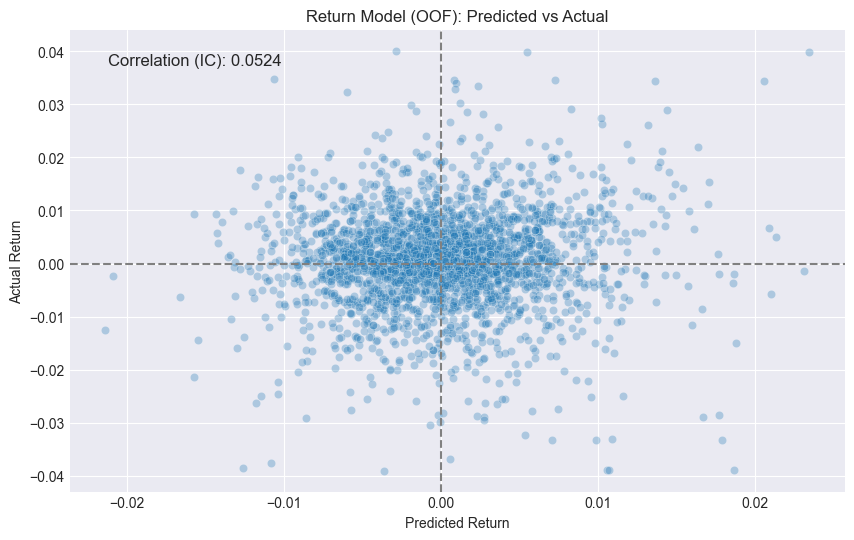

In [3]:
# Scatter Plot: Predicted vs Actual Return
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pred_return', y='actual_return', alpha=0.3)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Return Model (OOF): Predicted vs Actual')
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')

# 상관계수 계산
corr = df['pred_return'].corr(df['actual_return'])
plt.text(0.05, 0.95, f'Correlation (IC): {corr:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


## 3. Risk Model 검증 (True Performance)
OOF 예측 리스크와 실제 리스크(수익률 절대값)의 관계를 확인합니다.


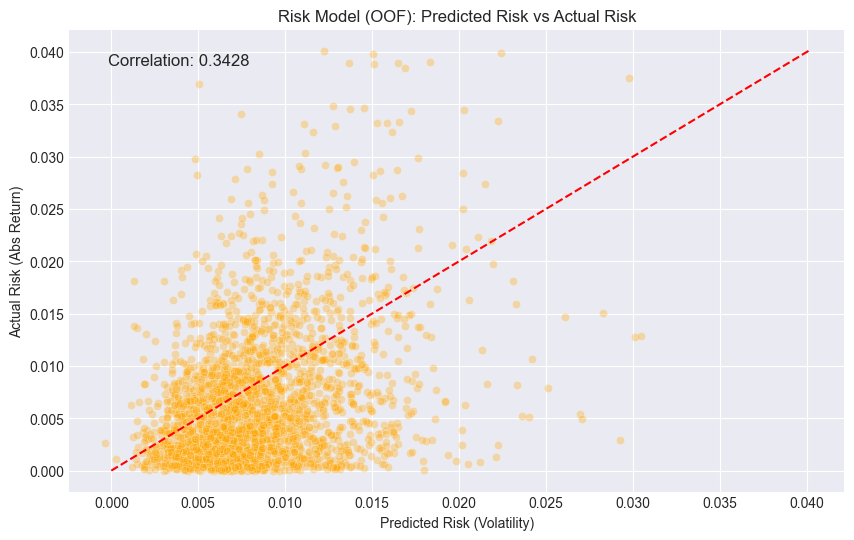

In [4]:
# Scatter Plot: Predicted Risk vs Actual Risk
# Actual Risk = abs(Actual Return)
df['actual_risk'] = df['actual_return'].abs()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pred_risk', y='actual_risk', alpha=0.3, color='orange')
# y=x line
max_val = max(df['pred_risk'].max(), df['actual_risk'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

plt.title('Risk Model (OOF): Predicted Risk vs Actual Risk')
plt.xlabel('Predicted Risk (Volatility)')
plt.ylabel('Actual Risk (Abs Return)')

# 상관계수
corr_risk = df['pred_risk'].corr(df['actual_risk'])
plt.text(0.05, 0.95, f'Correlation: {corr_risk:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


## 4. Strategy Simulation (Full Period)
OOF 예측값을 기반으로 한 전체 기간 시뮬레이션입니다.


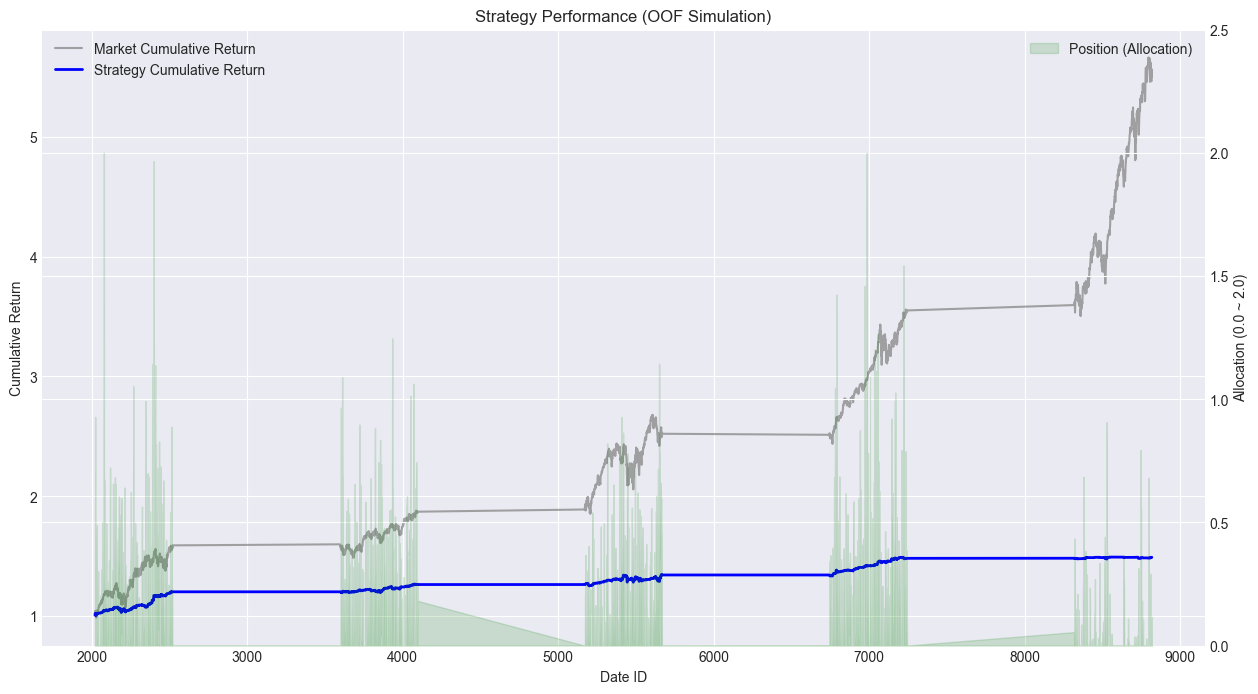

In [5]:
# 누적 수익률 계산
df['cum_market_return'] = (1 + df['actual_return']).cumprod()
df['strategy_return'] = df['allocation'] * df['actual_return']
df['cum_strategy_return'] = (1 + df['strategy_return']).cumprod()

# 시각화
fig, ax1 = plt.subplots(figsize=(15, 8))

# 시장 누적 수익률 (왼쪽 축)
ax1.plot(df['date_id'], df['cum_market_return'], label='Market Cumulative Return', color='gray', alpha=0.7)
ax1.plot(df['date_id'], df['cum_strategy_return'], label='Strategy Cumulative Return', color='blue', linewidth=2)
ax1.set_xlabel('Date ID')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')

# Allocation (오른쪽 축)
ax2 = ax1.twinx()
ax2.fill_between(df['date_id'], df['allocation'], color='green', alpha=0.15, label='Position (Allocation)')
ax2.set_ylabel('Allocation (0.0 ~ 2.0)')
ax2.set_ylim(0, 2.5) # 여백 확보
ax2.legend(loc='upper right')

plt.title('Strategy Performance (OOF Simulation)')
plt.show()


## 5. Risk-Based Allocation Check
Risk 예측값이 높을 때 실제로 Allocation이 줄어드는지 확인합니다.


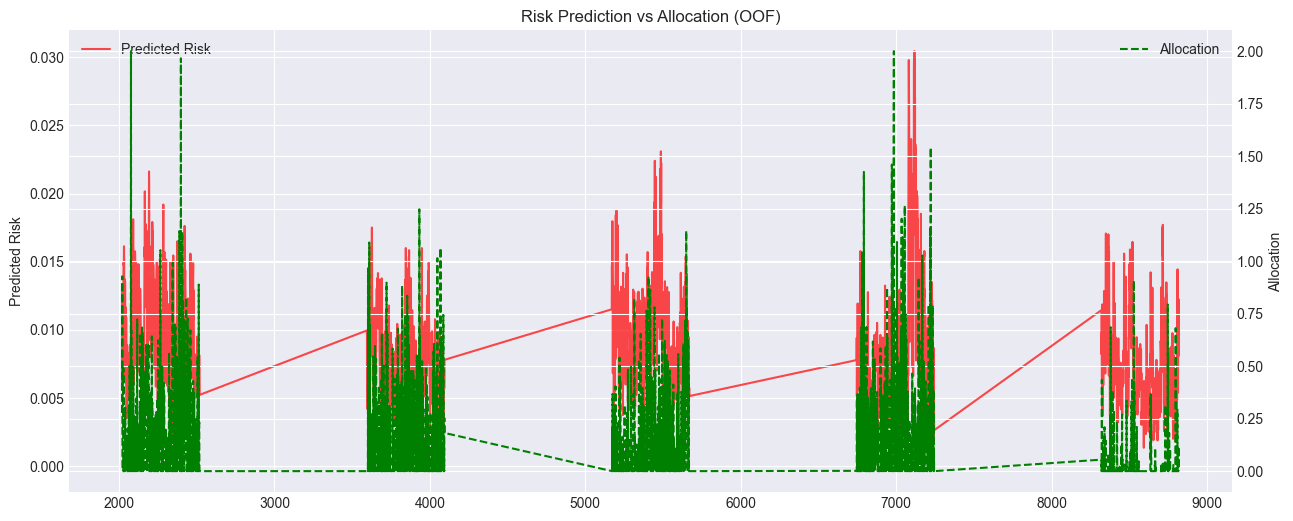

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))

# Predicted Risk
ax.plot(df['date_id'], df['pred_risk'], label='Predicted Risk', color='red', alpha=0.7)
ax.set_ylabel('Predicted Risk')
ax.legend(loc='upper left')

# Allocation
ax2 = ax.twinx()
ax2.plot(df['date_id'], df['allocation'], label='Allocation', color='green', linestyle='--')
ax2.set_ylabel('Allocation')
ax2.legend(loc='upper right')

plt.title('Risk Prediction vs Allocation (OOF)')
plt.show()
